# 1. Introduction

In [1]:
from functools import partial
from langid import langid
from konlpy.tag import Okt as Tag
from string import punctuation
from multiprocessing.pool import ThreadPool as Pool
from lyricsgenius import Genius
import regex as re
from tqdm import tqdm
from datetime import datetime
from time import sleep
from typing import Tuple
import tekore as tk
import urllib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from collections import defaultdict, Counter
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize #For languages that predominantly use spaces
from labMTsimple.storyLab import emotionFileReader
import networkx as nx
from networkx.algorithms.community.louvain import modularity, louvain_communities
import netwulf as nw
import random
import pickle as pkl

class Song:
    def __init__(self, ts, title, artists, id):
        self.title = title
        self.artists_raw = list(artists)
        self.artists = ", ".join(self.artists_raw)
        self.id = id
        self.ts = datetime.utcfromtimestamp(int(ts))
        self.a_n_t = f"{self.artists} - {self.title}"

    def __str__(self):
        return self.a_n_t

    def __repr__(self):
        return str(self)

    def __hash__(self):
        return hash(self.__repr__())

    def __eq__(self, other):
        return self.a_n_t.lower() == other.a_n_t.lower() or self.id == other.id
    
def song_from_track(t):
	return Song(0, t.name, map(lambda x: x.name, t.artists), t.id)

conf = tk.config_from_file("../tekore.conf", return_refresh=True)
client_id, client_secret, redirect_uri, user_refresh = conf
token = tk.refresh_user_token(client_id, client_secret, user_refresh)
sender = tk.RetryingSender(sender=tk.SyncSender())
spotify = tk.Spotify(token, sender=sender, max_limits_on=True, chunked_on=True)
current_user = spotify.current_user()

genius = Genius("KEFn0L8xkvDMGZive3aIXMuE6TB0aF2QwrWMDnhSdD_PEa9S_9129vPB38T-VKfb")
genius.verbose = False
genius.skip_non_songs = True

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Anders\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anders\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Motivation

## 2.1. Dataset

### 2.1.1. Spotify API

### 2.1.2. Everynoise.com

### 2.1.3. Genius API

## 2.2. Analysis and Goal

# 3. Data Acquisition and Stats

This section will both include the methods of data acquisition and stats regarding the data in the order it is retrieved.

To see how all the data is acquired, in each step the artist "Taylor Swift" will be used to show outputs of each step.

## 3.1. Spotify + Everynoise.com Data

The first thing we want to acquire is general information about the artists on which we will be basing the analysis. Below is the code for acquiring the artists from the Spotify API directly and then for scraping the genres from Everynoise.com.

In [2]:
#Code to obtain HTML of a site.
def get_site(URL):
	#print("Loading...")
	html = ''
	try:
		html = urllib.request.urlopen(URL).read()
	except Exception as e:
		print("Unexpected Error: ", e, " with url: ", URL)
	#print("Done.")
	return html

#Code to obtain genres of the artist directly through the url.
def getGenresOfName(name: str):
	URL = f"http://everynoise.com/lookup.cgi?who={urllib.parse.quote(name)}"
	html = str(get_site(URL))
	genres = re.findall('t>([A-z0-9- ]*)<', html)
	return genres

try: #Load if not ran before
    with open('../data/artists.pkl', 'rb') as f:
        artists = pkl.load(f)
except:
    #Start off with some playlists.
    playlists = ["275YVJvF53dkyJtJLk9rfn","0qWfVDFyF0Tj7wjhxkN1kJ","2qJJIA8WyjzUwLkTlb0C0e", "0hYDNLOLfEnzOqzbM9Okj2"]
    songs = []
    for plst in playlists:
        songs += list(spotify.all_items(spotify.playlist(plst, market="from_token").tracks))
        
    artists = {}

    #Add the predetermined songs to the dictionary.
    for s in songs:
        for a in s.track.artists:
            artists[a.name] = {}
            artists[a.name]['id'] = a.id
            artists[a.name]['separation'] = 1
            artists[a.name]['genres'] = getGenresOfName(a.name)
            
    artists_checked = set()
    artist_related = defaultdict(lambda:[])

    #Step through each depth
    for i in range(3):
        next_degree_artists = []
        for a,data in tqdm(list(artists.items())):
            if data['id'] is None or data['id'] in artists_checked:
                continue
            try:
                for a2 in spotify.artist_related_artists(data['id']):
                    artist_related[a].append(a2.name)
                    if a2.id in artists_checked:
                        continue
                    artists[a2.name] = {}
                    artists[a2.name]['separation'] = artsts[a]['separation']+1
                    artists[a2.name]['genres'] = getGenresOfName(a2.name)
                    next_degree_artists.append(artists[a2.name])
            except KeyboardInterrupt:
                break
            except Exception as e:
                print("Fail on ", a, data['id'])
                print(e)
                continue
            artists_checked.add(data['id'])
            #sleep(0.1)
        artists.update(next_degree_artists)

To start off the data, some playlists are chosen as a starting point for the artists.
Since there is a rate limit of the Spotify API, the data will only be acquired to a depth of 3.
For each depth the above for loop goes through each artist and checks if they have been passed through the API.
If not, then the API is requested to retrieve all related artists.

Below shows the example of retrieving the related artists for "Taylor Swift":

She has ID: "06HL4z0CvFAxyc27GXpf02"

In [3]:
for i,a in enumerate(spotify.artist_related_artists(artists['Taylor Swift']['id'])):
    print(f"{i+1}.\t{a.name:<25}\twith ID {a.id}")

1.	Demi Lovato              	with ID 6S2OmqARrzebs0tKUEyXyp
2.	Alessia Cara             	with ID 2wUjUUtkb5lvLKcGKsKqsR
3.	Lorde                    	with ID 163tK9Wjr9P9DmM0AVK7lm
4.	Selena Gomez             	with ID 0C8ZW7ezQVs4URX5aX7Kqx
5.	Troye Sivan              	with ID 3WGpXCj9YhhfX11TToZcXP
6.	ZAYN                     	with ID 5ZsFI1h6hIdQRw2ti0hz81
7.	Miley Cyrus              	with ID 5YGY8feqx7naU7z4HrwZM6
8.	Fifth Harmony            	with ID 1l8Fu6IkuTP0U5QetQJ5Xt
9.	Niall Horan              	with ID 1Hsdzj7Dlq2I7tHP7501T4
10.	Harry Styles             	with ID 6KImCVD70vtIoJWnq6nGn3
11.	Carly Rae Jepsen         	with ID 6sFIWsNpZYqfjUpaCgueju
12.	Camila Cabello           	with ID 4nDoRrQiYLoBzwC5BhVJzF
13.	Jonas Brothers           	with ID 7gOdHgIoIKoe4i9Tta6qdD
14.	Julia Michaels           	with ID 0ZED1XzwlLHW4ZaG4lOT6m
15.	One Direction            	with ID 4AK6F7OLvEQ5QYCBNiQWHq
16.	Halsey                   	with ID 26VFTg2z8YR0cCuwLzESi2
17.	Meghan Trainor           	wit

These artists are thus added to the related artists of Taylor Swift and are further added to be searched next in the acquisition.

Note that Spotify has a related artists algorithm which will with the best of its ability try to retrieve 20 related artists of each artists. Which means we will generally have a branching factor of 20 in the graph. Some artists, however, are unknown, have corrupt metadata or have obscure origins and as such will therefore have less than 20 artists. But this is rare in the dataset.

Next, the genre is scraped from Everynoise.com. This is done simply by getting the HTML directly through the URL with the artist's name inserted as the %s search string. Regular Expressions is then used to extract the genres which are simply in a DIV inside the HTML.

An example of the genres returned for "Taylor Swift":

In [4]:
print(getGenresOfName("Taylor Swift"))

['pop']


Here Taylor Swift only has the single genre "pop" according to Everynoise.com. Another artist might have multiple genres, such as ["pop", "rock", "country"].

The size of the dataset after 3 passes is as follows:

There are 4425 unique genres.
There are  90815 artists.

The following genres are the most prevalent:
1.	pop            :	579 artists
2.	electro house  :	566 artists
3.	dance pop      :	563 artists
4.	edm            :	500 artists
5.	indie pop      :	489 artists
6.	hip hop        :	456 artists
7.	rock           :	455 artists
8.	pop rap        :	451 artists
9.	electropop     :	450 artists
10.	modern rock    :	440 artists


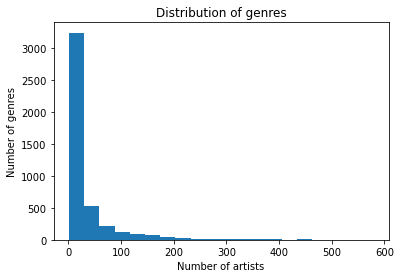

In [5]:
genres = set(g for _,data in artists.items() for g in data['genres'])
genre_prevalence = Counter()
for a,data in artists.items():
    for g in data['genres']:
        genre_prevalence[g] += 1

print("There are", len(genres), "unique genres.")
print("There are ", len(artists), "artists.")
print()
print("The following genres are the most prevalent:")
for i, (g, num) in enumerate(genre_prevalence.most_common(10)):
    print(f"{i+1}.\t{g:<15}:\t{num} artists")

plt.hist(list(genre_prevalence.values()), bins=20)
plt.xlabel("Number of artists")
plt.ylabel("Number of genres")
plt.title("Distribution of genres")
plt.show()

The last plot shows the distribution of artists over genres. As seen, most genres are quite small (less than 20 artists). Note: an artist can have multiple genres assigned, which means lesser known genres can still appear even though the artist has an overarching genre.

Also, remarkably, after only three passes there are already 90.8k artists in the dataset.

## 3.2. Genius Lyrics Data

The next thing to gather is the lyrics of the songs of the artists. At first we wanted to retrieve multiple songs from each artist, but due to time limits, the rate limit and the size of the data (1.2 GB for 1 song for 90.8k artists) we ended up only retrieving the first song.

The Spotify API can be used to retrieve the top songs of an artist. As such, the top song for each artis was retrieved. The Genius API can be used to search for lyrics by song title and artist.

Below is the code for retrieving the top artsts and the lyrics from Genius API for each artist in the dataset:

In [6]:
#Spotify API returns top 10 (or less) songs of an artist by current popularity
def getTop10Tracks(artist_id: str):
    return [song_from_track(t) for t in spotify.artist_top_tracks(artist_id, "US")]

#Query the Genius API for the lyrics of an artist's top songs.
#Returns a list of Genius Metadata for the songs.
#If failure to retreive, returns "FAILED"
#If lyrics not found or the song does not have lyrics, returns None.
def getTopNLyrics(artist_info: Tuple[str, str], n: int = 10):
    artist_name, artist_id = artist_info
    lyrics = []
    for song in getTop10Tracks(artist_id)[:n]:
        try:
            song_lyrics = genius.search_song(song.title, artist_name, get_full_info=False)
            sleep(0.5)
            lyrics.append((artist_name, artist_id, song, song_lyrics))
        except Exception as e:
            sleep(2.0)
            lyrics.append((artist_name, artist_id, song, "FAILED"))
            print(e)
    return lyrics

NUM_TOP_SONGS = 1

try:
    with open(f"../data/lyrics_cache_top{NUM_TOP_SONGS}.pkl", "rb") as f:
        lyrics_cache = pkl.load(f)
except:
    with tqdm(total=len(artists)) as pbar:
        for i in range(0, len(artists), 1000):
            #Multiprocessing to speed up the process of retrieval.
            with Pool(processes=12) as pool:
                lyrics_cache.extend(pool.map(partial(getTopNLyrics, n=NUM_TOP_SONGS), [(name, data["id"]) for name, data in list(artists.items())[i:i+1000]]))
                pbar.update(1000)
                with open(f"lyrics_cache_top{NUM_TOP_SONGS}.pkl", "wb") as f:
                    pkl.dump(lyrics_cache, f)

Above are the two functions needed to retrieve the lyrics. First the top songs which are directly retrieved from the Spotify API. The second function is used to search for lyrics by song title and artist on Genius. Finally, the process is sped up using multiprocessing while still waiting when the rate limit is reached (sleep in second function).

Note on the top songs: The songs are sorted by Spotify's own algorithmic popularity, which is not only based on the total number of plays of a song but also based on the current monthly listeners (and there might be other factors as well, i.e. featured songs, etc.).

Below are the lyrics to the top song for "Taylor Swift":

In [7]:
taylor_song = getTop10Tracks(artists['Taylor Swift']['id'])[0]
print("Taylor Swift's Top Song:")
print(taylor_song)
print()
taylor_genius = getTopNLyrics(('Taylor Swift',artists['Taylor Swift']['id']), 1)[0][-1]
taylor_lyrics = taylor_genius.lyrics
print("With the raw unfiltered/uncleaned lyrics:")
print()
print(taylor_lyrics)

Taylor Swift's Top Song:
Taylor Swift - All Too Well (10 Minute Version) (Taylor's Version) (From The Vault)

With the raw unfiltered/uncleaned lyrics:

All Too Well (10 Minute Version) (Taylor’s Version) [From the Vault] Lyrics[Verse 1]
I walked through the door with you, the air was cold
But somethin' 'bout it felt like home somehow
And I left my scarf there at your sister's house
And you've still got it in your drawer, even now

[Verse 2]
Oh, your sweet disposition and my wide-eyed gaze
We're singin' in the car, getting lost upstate
Autumn leaves fallin' down like pieces into place
And I can picture it after all these days

[Pre-Chorus]
And I know it's long gone and
That magic's not here no more
And I might be okay, but I'm not fine at all
Oh, oh, oh
[Chorus]
'Causе there we arе again on that little town street
You almost ran the red 'cause you were lookin' over at me
Wind in my hair, I was there
I remember it all too well

[Verse 3]
Photo album on the counter, your cheeks were turn

As seen, the song is quite abnormally long (10 minutes) and as such the lyrics are quite long, too. Also note how the lyrics begin with the title of the song and then " Lyrics" and it ends with "199Embed". These are just artifacts of the Genius API metadata embedded into the lyrics.
These will be cleaned up in the next step where the lyrics are tokenized.

## 3.3. Tokenization and Sentiment Scores
The next step consists of four parts:

    1. Detecting the language of the lyrics
    2. Pre-processing the lyrics
    3. Tokenizing the lyrics
    4. Getting the LabMT sentiment values

In [8]:
get_sentiments = False
try:
    df = pd.read_pickle("../data/lyrics_sentiment.pkl")
except:
    get_sentiments = True

#Available languages: English, French, German, Hindi, Indonesian, Korean, Portuguese, Russian, Spanish.
languages = ['english','french','german','hindi','indonesian','korean','portuguese','russian','spanish']
languages_short = set(['en', 'fr', 'de', 'hi', 'id', 'ko', 'pt', 'ru', 'es'])

#Make a combined dictionary of sentiment scores
token_sentiment = {}
for lang in languages:
    _, vector, words = emotionFileReader(stopval=0.0,lang=lang, returnVector=True)
    for word, value in zip(words,vector):
        token_sentiment[word.lower()] = value

#Language detection
lang_classify = langid.LanguageIdentifier.from_modelstring(langid.model, norm_probs=True).classify
#Translation table to remove punctuation
table = str.maketrans('', '', punctuation)

if get_sentiments:
    #Korean tokenizer
    konlpy_tokenize = partial(Tag().morphs,norm=True)
    
    df = pd.DataFrame(columns=['artist_id','artist_name','song_id','song_name','lyric_tokens','sentiment','language'])

    missing_lyrics = set()
    with tqdm(total=len(lyrics_cache)) as pbar:
        while len(lyrics_cache) > 0:
            song_data = lyrics_cache.pop()
            pbar.update(1)
            for artist_name, artist_id, song, lyric in song_data:
                if lyric is None or lyric == "FAILED" or len(lyric.lyrics) > 10000:
                    missing_lyrics.add(artist_id)
                    continue
                #Get lyrics raw text
                lyric_text = lyric.lyrics
                
                #Clean up genius annotations
                genius_intro = lyric.title+" Lyrics"
                if lyric_text.startswith(genius_intro):
                    lyric_text = lyric_text[len(genius_intro):]
                if lyric_text.endswith("Embed"):
                    lyric_text = lyric_text[:-5]
                
                #Detect language
                language_family, prob = lang_classify(lyric_text) #Step 1.
                # Select tokenizer based on language
                if not language_family in languages_short or prob < 0.5: #Step 2.
                    continue #Skip if unknown language or low confidence
                elif language_family == 'ko':
                    tokenize_func = konlpy_tokenize
                else:
                    tokenize_func = word_tokenize
                
                #Clean up lyrics
                lyric_text = lyric_text.translate(table).lower() #Remove punctuation
                
                tokens = [] #Tokens for this lyric
                sentiment = [] #Sentiment for each token
                has_sentiment = [] #Whether or not the token has sentiment score in LabMT
                for tok in tokenize_func(lyric_text): #Step 3.
                    tokens.append(tok)
                    sentiment.append(token_sentiment.get(tok, 5)-5) #-5 to center LabMT sentiment scores around 0, Step 4.
                    has_sentiment.append(tok in token_sentiment)
                df = df.append({'artist_id':artist_id,
                                'artist_name':artist_name,
                                'song_id':song.id,
                                'song_name':song.title,
                                'lyric_tokens':tokens,
                                'sentiment':sentiment,
                                'has_sentiment':has_sentiment,
                                'language':language_family},
                            ignore_index=True)

Before anything else, the aforementioned metadata artifacts are removed from the lyrics. 

Then using the Lang Id Clasifier [1] the language of the lyrics is determined. If the language could not be detected (the model was uncertain about the primary language), or if it primarily contains a language not supported by the LabMT sentiment scoring [2] [3], then the artist/song is skipped.

The tokenizer is chosen based on the language detected. If the language is Korean, then a tokenizer from KoNLPy [4] is used. The specific tokenizer is the Open Korean Text by Will Hohyon Ryu [5]. This tokenizer provides Korean segmentation, normalization and stemming so that the segmented tokens can be looked up in the LabMT Korean sentiment dictionary. Otherwise, the NLTK word tokenizer [6] is used.

After a tokenizer is chosen the lyrics are cleaned up for punctuation and converted to lower-case.

After pre-processing, the lyrics are tokenized using the respective tokenizer and the tokens and their sentimental values are saved to the dataframe.

Note: Due to some dirty crowdsourced data, lyrics with more than 10,000 characters are skipped to avoid spam or other unwanted data.

Here are examples of all steps applied to the lyrics of the top song of "Taylor Swift":

In [9]:
genius_intro = taylor_genius.title+" Lyrics"

if taylor_lyrics.startswith(genius_intro):
    taylor_lyrics = taylor_lyrics[len(genius_intro):]
if taylor_lyrics.endswith("Embed"):
    taylor_lyrics = taylor_lyrics[:-5]
    
print("Cleaned genius artifacts, here the first 200 characters of the lyrics:")
print()
print(taylor_lyrics[:200])
print("Note the title is now removed in the beginning.")
print("-----------------------------------------------------------")
taylor_lyrics = taylor_lyrics.translate(table).lower()
print("Cleaned up punctuation and lower case, here the first 200 characters of the lyrics:")
print()
print(taylor_lyrics[:200])
print()
taylor_tokens = [tok for tok in word_tokenize(taylor_lyrics)]
taylor_sentiments = [token_sentiment.get(tok, 5)-5 for tok in taylor_tokens]
taylor_mean_sentiment = np.mean(taylor_sentiments)
taylor_mean_emotion = np.mean(np.abs(taylor_sentiments))
print("Here are the first 15 tokens of the cleaned lyrics:")
print(" | ".join([f"{tok:^7}" for tok in taylor_tokens[:13]]))
print(" | ".join([f"{sen:^7.4g}" for sen in taylor_sentiments[:13]]))
print()
taylor_language,taylor_language_prob = lang_classify(taylor_lyrics)
print(f"Taylor Swift's language is '{taylor_language}' with probability {taylor_language_prob}")
print(f"Taylor Swift's mean sentiment (over the whole song) is {taylor_mean_sentiment:.4g}")
print(f"Taylor Swift's mean emotion (over the whole song) is {taylor_mean_emotion:.4g}")

Cleaned genius artifacts, here the first 200 characters of the lyrics:

[Verse 1]
I walked through the door with you, the air was cold
But somethin' 'bout it felt like home somehow
And I left my scarf there at your sister's house
And you've still got it in your drawer, ev
Note the title is now removed in the beginning.
-----------------------------------------------------------
Cleaned up punctuation and lower case, here the first 200 characters of the lyrics:

verse 1
i walked through the door with you the air was cold
but somethin bout it felt like home somehow
and i left my scarf there at your sisters house
and youve still got it in your drawer even now



Here are the first 15 tokens of the cleaned lyrics:
 verse  |    1    |    i    | walked  | through |   the   |  door   |  with   |   you   |   the   |   air   |   was   |  cold  
 0.84   |    0    |  0.12   |    1    |   0.2   |   0.2   |  -0.68  |  0.94   |  1.58   |   0.2   |  1.62   |  -0.16  |  -0.54 

Taylor Swift's language

As shown, the language was detected as English with 100% certainty, and her lyrics are generally emotional and with a positive sentiment.

Note that "verse" has a positive sentiment, even though it is not directly part of the lyrics and is a meta-part of the lyrics representation. This will be fixed later when the sentiment analysis is performed by removing meta-parts.

Below are the number of songs for each language:

In [15]:
print(df.groupby(['language']).count()['has_sentiment'])

language
de     1133
en    38496
es     1929
fr     1068
hi       12
id      147
ko      664
pt     1084
ru      299
Name: has_sentiment, dtype: int64


Below is the distribution of lyric lengths:

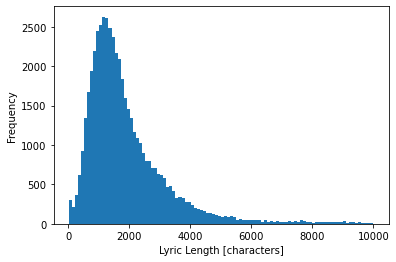

In [16]:
lyric_lengths = Counter()
for song_data in lyrics_cache:
    for artist_name, artist_id, song, lyric in song_data:
        if lyric is not None and lyric != "FAILED" and len(lyric.lyrics) < 10000:
            lyric_lengths[lyric] = len(lyric.lyrics)
plt.hist(lyric_lengths.values(), bins=100)
plt.xlabel("Lyric Length [characters]")
plt.ylabel("Frequency")
plt.show()

The mean length of lyrics seems to be around 1600 characters.

# 4. Tools, Theory and Analysis

## 4.1. General Sentiment Analysis

## 4.2. Moving Average Sentiment Analysis

## 4.3. Community Detection and Modularity

## 4.5. Word Clouds and Most Relevant Words

# 5. Discussion

## 5.1. Related Aratists
## 5.2. Language Issue
## 5.3. Algorithmically Confoundedness
## 5.4. Missing and crowdsourced Data

# 6. References

[1] Lui, Marco and Timothy Baldwin (2011) Cross-domain Feature Selection for Language Identification, In Proceedings of the Fifth International Joint Conference on Natural Language Processing (IJCNLP 2011), Chiang Mai, Thailand, pp. 553—561. Available from http://www.aclweb.org/anthology/I11-1062

[2] Dodds, Peter Sheridan, Kameron Decker Harris, Isabel M. Kloumann, Catherine A. Bliss, and Christopher M. Danforth. "Temporal patterns of happiness and information in a global social network: Hedonometrics and Twitter." PLoS ONE 6, no. 12 (2011). https://github.com/ryanjgallagher/shifterator/tree/master/shifterator/lexicons/labMT

[3] Dodds, Peter Sheridan, Eric M. Clark, Suma Desu, Morgan R. Frank, Andrew J. Reagan, Jake Ryland Williams, Lewis Mitchell et al. "Human language reveals a universal positivity bias." Proceedings of the National Academy of Sciences 112, no. 8 (2015): 2389-2394. https://github.com/ryanjgallagher/shifterator/tree/master/shifterator/lexicons/labMT

[4] Eunjeong L. Park, Sungzoon Cho. “KoNLPy: Korean natural language processing in Python”, Proceedings of the 26th Annual Conference on Human & Cognitive Language Technology, Chuncheon, Korea, Oct 2014. https://konlpy.org/en/latest/#

[5] Will Hohyon Ryu, Open Korean Text. https://github.com/open-korean-text/open-korean-text

[6] Bird, Steven, Edward Loper and Ewan Klein (2009).
Natural Language Processing with Python.  O'Reilly Media Inc. https://github.com/nltk/nltk